In this notebook we are going to perform an exploratory analysis of the data regarding the power production collected from the DATA CELLAR API.

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd
from utils_ae import *
from postprocessing import *
from lstm_ae import *

### Training and Testing

ATTENZIONE: va fatto un resampling per quanto riguarda le date perchè a quanto pare ci sono date mancanti

In [4]:
t = pd.read_csv("/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/production_ts.csv")
t

Unnamed: 0        utc_timestamp  solar_generation_actual country_code
0                0  2016-01-01 00:00:00                      0.0           AT
1                1  2016-01-01 01:00:00                      0.0           AT
2                2  2016-01-01 02:00:00                      0.0           AT
3                3  2016-01-01 03:00:00                      0.0           AT
4                4  2016-01-01 04:00:00                      0.0           AT
...            ...                  ...                      ...          ...
342571      342571  2016-12-31 19:00:00                      0.0           SK
342572      342572  2016-12-31 20:00:00                      1.7           SK
342573      342573  2016-12-31 21:00:00                      1.4           SK
342574      342574  2016-12-31 22:00:00                      1.0           SK
342575      342575  2016-12-31 23:00:00                      0.0           SK

[342576 rows x 4 columns]

In [5]:
t.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
t

utc_timestamp  solar_generation_actual country_code
0       2016-01-01 00:00:00                      0.0           AT
1       2016-01-01 01:00:00                      0.0           AT
2       2016-01-01 02:00:00                      0.0           AT
3       2016-01-01 03:00:00                      0.0           AT
4       2016-01-01 04:00:00                      0.0           AT
...                     ...                      ...          ...
342571  2016-12-31 19:00:00                      0.0           SK
342572  2016-12-31 20:00:00                      1.7           SK
342573  2016-12-31 21:00:00                      1.4           SK
342574  2016-12-31 22:00:00                      1.0           SK
342575  2016-12-31 23:00:00                      0.0           SK

[342576 rows x 3 columns]

In [7]:
t.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342576 entries, 0 to 342575
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   utc_timestamp            342576 non-null  object 
 1   solar_generation_actual  306629 non-null  float64
 2   country_code             342576 non-null  object 
dtypes: float64(1), object(2)
memory usage: 7.8+ MB


There are null values in the $solar\_generation\_actual$ column. Let's check if for each country the number of dates is correct, and no dates are missing.

In [8]:
t.groupby(['country_code']).count()

utc_timestamp  solar_generation_actual
country_code                                        
AT                     8784                     8736
BE                     8784                     8784
BG                     8784                     8784
CH                     8784                     8760
CZ                     8784                     8784
DE                     8784                     8712
DE50hertz              8784                     8784
DELU                   8784                        0
DEamprion              8784                     8784
DEtennet               8784                     8784
DEtransnetbw           8784                     8784
DK                     8784                     8784
DK1                    8784                     8784
DK2                    8784                     8784
EE                     8784                     8772
ES                     8784                     8784
FR                     8784                     8784
GBGBN                  8784                     8784
GBUKM                  8784                     8784
GR                     8784                     8779
HR                     8784                        0
HU                     8784                        0
IT                     8784                     8784
ITCNOR                 8784                     8784
ITCSUD                 8784                     8784
ITFOGN                 8784                     8784
ITNORD                 8784                     8784
ITPRGP                 8784                     8784
ITROSN                 8784                     8784
ITSARD                 8784                     8784
ITSICI                 8784                     8784
ITSUD                  8784                     8784
LT                     8784                     8252
NL                     8784                     8666
PL                     8784                        0
PT                     8784                     8784
RO                     8784                     8784
SI                     8784                     8784
SK                     8784                     8784

We can see how some countries do not have values for what concerns the solar generation records, so they can be dropped out as it would make no sense to fill them out. Around 6 countries have missing values.

In [9]:
no_countries = ['DELU', 'HR', 'HU', 'PL']
tt = t[t.country_code.isin(no_countries) == False]
tt

utc_timestamp  solar_generation_actual country_code
0       2016-01-01 00:00:00                      0.0           AT
1       2016-01-01 01:00:00                      0.0           AT
2       2016-01-01 02:00:00                      0.0           AT
3       2016-01-01 03:00:00                      0.0           AT
4       2016-01-01 04:00:00                      0.0           AT
...                     ...                      ...          ...
342571  2016-12-31 19:00:00                      0.0           SK
342572  2016-12-31 20:00:00                      1.7           SK
342573  2016-12-31 21:00:00                      1.4           SK
342574  2016-12-31 22:00:00                      1.0           SK
342575  2016-12-31 23:00:00                      0.0           SK

[307440 rows x 3 columns]

In [13]:
tt.utc_timestamp = pd.to_datetime(tt.utc_timestamp)

In [62]:
visualization = tt[tt.country_code == "AT"] #AT, NL, LT, GR, EE, CH, DE
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualization.utc_timestamp, y=visualization['solar_generation_actual'], name='solar_production'))
fig.update_layout(showlegend=True, title='Solar Production')
fig.show()

In [75]:
vis = visualization.copy()

In [76]:
# Creiamo una maschera booleana per identificare i NaN
is_na = vis['solar_generation_actual'].isna()

# Trova i gruppi di NaN consecutivi, assegnando un identificativo unico a ciascun gruppo
# Questo funziona creando un gruppo ogni volta che is_na cambia (cioè da False a True o viceversa)
vis['na_group'] = (is_na != is_na.shift()).cumsum() * is_na

# Ora calcola la lunghezza di ogni gruppo di NaN e trova il più lungo
na_lengths = vis.groupby('na_group').size()
longest_na_group = na_lengths[na_lengths.index != 0].idxmax()  # Escludi il gruppo 0, che non è NaN

# Ottieni la lunghezza della sequenza di NaN più lunga e le sue posizioni
longest_na_length = na_lengths[longest_na_group]
start_index = vis[vis['na_group'] == longest_na_group].index[0]
end_index = vis[vis['na_group'] == longest_na_group].index[-1]

print(f"La sequenza di NaN più lunga ha una lunghezza di {longest_na_length}, dall'indice {start_index} all'indice {end_index}.")

# Rimuove la colonna temporanea
vis.drop(columns=['na_group'], inplace=True)

La sequenza di NaN più lunga ha una lunghezza di 24, dall'indice 3645 all'indice 3668.


In [77]:
iterations = int(np.ceil(longest_na_length / 24))
iterations

1

In [78]:
for i in range(iterations):
    vis.solar_generation_actual = vis.solar_generation_actual.fillna(vis.solar_generation_actual.shift(24))

In [79]:
#vis.solar_generation_actual = vis.solar_generation_actual.fillna(vis.solar_generation_actual.shift(24))
fig = go.Figure()
fig.add_trace(go.Scatter(x=vis.utc_timestamp, y=vis['solar_generation_actual'], name='solar_production'))
fig.update_layout(showlegend=True, title='Solar Production')
fig.show()

In [80]:
vis.set_index('utc_timestamp', inplace = True)

In [82]:
vis

solar_generation_actual country_code
utc_timestamp                                            
2016-01-01 00:00:00                      0.0           AT
2016-01-01 01:00:00                      0.0           AT
2016-01-01 02:00:00                      0.0           AT
2016-01-01 03:00:00                      0.0           AT
2016-01-01 04:00:00                      0.0           AT
...                                      ...          ...
2016-12-31 19:00:00                      0.0           AT
2016-12-31 20:00:00                      0.0           AT
2016-12-31 21:00:00                      0.0           AT
2016-12-31 22:00:00                      0.0           AT
2016-12-31 23:00:00                      0.0           AT

[8784 rows x 2 columns]

In [91]:
res = vis['solar_generation_actual'].resample("15min").sum()

In [92]:
res

utc_timestamp
2016-01-01 00:00:00    0.0
2016-01-01 00:15:00    0.0
2016-01-01 00:30:00    0.0
2016-01-01 00:45:00    0.0
2016-01-01 01:00:00    0.0
                      ... 
2016-12-31 22:00:00    0.0
2016-12-31 22:15:00    0.0
2016-12-31 22:30:00    0.0
2016-12-31 22:45:00    0.0
2016-12-31 23:00:00    0.0
Freq: 15min, Name: solar_generation_actual, Length: 35133, dtype: float64

In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=res.index, y=res.values, name='solar_production'))
fig.update_layout(showlegend=True, title='Solar Production')
fig.show()

Now we need to proceed by dividing the dataset into a train and test set, based on the dates (so, the first 80% of data should fall within the training set). Then we proceed by creating windows of a certain length for each of the two sets.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
tt2 = tt[['generation_kwh']]

In [9]:
df_train, df_test = train_test_split(tt2, test_size = 0.2, shuffle = False)

In [10]:
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle = False)

In [11]:
df_train

generation_kwh
0               0.00
1               0.00
2               0.00
3               0.00
4               0.00
...              ...
3195            4.33
3196            5.41
3197            3.23
3198            2.64
3199            0.92

[3200 rows x 1 columns]

In [12]:
df_test

generation_kwh
4000            0.00
4001            0.00
4002            0.00
4003            0.00
4004            0.00
...              ...
4995           15.08
4996           14.90
4997           13.18
4998            9.15
4999            1.78

[1000 rows x 1 columns]

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['generation_kwh'], name='production_train'))
fig.add_trace(go.Scatter(x=df_val.index, y=df_val['generation_kwh'], name='production_val'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['generation_kwh'], name='production_test'))
fig.update_layout(showlegend=True, title='Energy Production')
fig.show()

In [14]:
def create_sequences(dataframe, time_steps, stride = 1):
    sequences = []
    for i in range(0, len(dataframe) - time_steps + 1, stride):
        #end of sequence
        end_idx = i + time_steps
        if end_idx <= len(dataframe)+1:
            slice = dataframe[i: (i + time_steps), :]
        sequences.append(slice)
    return np.stack(sequences)

In [15]:
test = df_test.reset_index(drop = True)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
X_train = scaler.fit_transform(df_train)
X_val = scaler.transform(df_val)
X_test = scaler.transform(test)

In [17]:
train_seq = create_sequences(X_train, 48)

In [18]:
train_seq.shape

(3153, 48, 1)

In [19]:
val_seq = create_sequences(X_val, 48)
val_seq.shape

(753, 48, 1)

In [20]:
test_seq = create_sequences(X_test, 48, 48)

In [21]:
test_seq.shape

(20, 48, 1)

In [22]:
BATCH_SIZE =  128
N_EPOCHS = 50
hidden_size = 1/8

In [23]:
w_size = train_seq.shape[1] * train_seq.shape[2]
n_channels = train_seq.shape[2]
z_size = int(w_size * hidden_size)
w_size, z_size

(48, 6)

In [24]:
# Linear_ae:
#train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(train_seq).float().view(([train_seq.shape[0], w_size])), torch.from_numpy(train_seq).float().view(([train_seq.shape[0], w_size]))), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
# Lstm_Ae:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(train_seq).float()), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(val_seq).float()), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

In [25]:
device = get_default_device()
device

device(type='cpu')

In [26]:
model = LstmAE(train_seq.shape[2], 32, 48)
model = to_device(model,device)

In [27]:
print(model)

LstmAE(
  (encoder): Encoder(
    (lstm): LSTM(1, 32, batch_first=True, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (lstm): LSTM(32, 32, batch_first=True, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [28]:
from torchinfo import summary

# Supponendo che il modello sia già creato e definito
summary(model.encoder, input_size=(128, train_seq.shape[1], train_seq.shape[2]))


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 128, 32]              --
├─LSTM: 1-1                              [128, 48, 32]             4,480
├─Dropout: 1-2                           [1, 128, 32]              --
Total params: 4,480
Trainable params: 4,480
Non-trainable params: 0
Total mult-adds (M): 27.53
Input size (MB): 0.02
Forward/backward pass size (MB): 1.57
Params size (MB): 0.02
Estimated Total Size (MB): 1.62

In [29]:
summary(model.decoder, input_size=(1, 128, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 48, 1]              --
├─LSTM: 1-1                              [128, 48, 32]             8,448
├─Dropout: 1-2                           [128, 48, 32]             --
├─Linear: 1-3                            [128, 48, 1]              33
Total params: 8,481
Trainable params: 8,481
Non-trainable params: 0
Total mult-adds (M): 51.91
Input size (MB): 0.02
Forward/backward pass size (MB): 1.62
Params size (MB): 0.03
Estimated Total Size (MB): 1.67

In [30]:
history = training(N_EPOCHS,model,train_loader,val_loader, device) 

Epoch [0], train_loss: 0.1978, val_loss: 0.1301
Epoch [1], train_loss: 0.1968, val_loss: 0.1287
Epoch [2], train_loss: 0.1968, val_loss: 0.1284
Epoch [3], train_loss: 0.1965, val_loss: 0.1287
Epoch [4], train_loss: 0.1962, val_loss: 0.1286
Epoch [5], train_loss: 0.1960, val_loss: 0.1283
Epoch [6], train_loss: 0.1959, val_loss: 0.1281
Epoch [7], train_loss: 0.1958, val_loss: 0.1277
Epoch [8], train_loss: 0.1958, val_loss: 0.1276
Epoch [9], train_loss: 0.1957, val_loss: 0.1275
Epoch [10], train_loss: 0.1956, val_loss: 0.1274
Epoch [11], train_loss: 0.1956, val_loss: 0.1275
Epoch [12], train_loss: 0.1955, val_loss: 0.1271
Epoch [13], train_loss: 0.1955, val_loss: 0.1271
Epoch [14], train_loss: 0.1955, val_loss: 0.1273
Epoch [15], train_loss: 0.1954, val_loss: 0.1270
Epoch [16], train_loss: 0.1953, val_loss: 0.1266
Epoch [17], train_loss: 0.1952, val_loss: 0.1265
Epoch [18], train_loss: 0.1944, val_loss: 0.1258
Epoch [19], train_loss: 0.1939, val_loss: 0.1249
Epoch [20], train_loss: 0.1927

In [31]:
def plot_history(history):
    plt.plot(history) #, label = "Evaluation loss"
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Evaluation loss through epochs')
    plt.grid()
    plt.show()

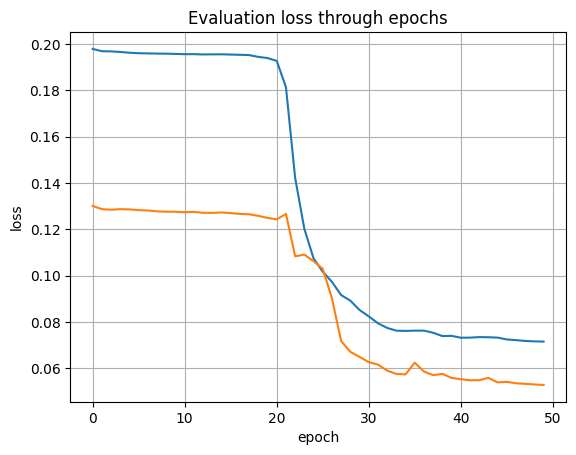

In [32]:
plot_history(history)

In [33]:
val_eval_seq = create_sequences(X_val, 48, 48)
val_eval_seq.shape

(16, 48, 1)

In [34]:
val_eval_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(val_eval_seq).float()
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 

In [35]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(test_seq).float()
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [36]:
results, w = testing(model, test_loader, device)

In [37]:
r = w[0].flatten().detach().cpu().numpy()

In [38]:
r.shape

(960,)

In [39]:
def get_predicted_dataset(test, reconstruction):
  test['reconstruction'] = reconstruction
  test['abs_loss'] = np.abs(test.generation_kwh - test.reconstruction)
  test['rel_loss'] = np.abs((test['reconstruction']-test['generation_kwh'])/test['reconstruction'])
  return test

In [40]:
df_t = get_predicted_dataset(pd.DataFrame(X_test[:960], columns=['generation_kwh']), r)
df_t

generation_kwh  reconstruction  abs_loss  rel_loss
0               0.0        0.023627  0.023627       1.0
1               0.0        0.015318  0.015318       1.0
2               0.0        0.028971  0.028971       1.0
3               0.0        0.035765  0.035765       1.0
4               0.0        0.054272  0.054272       1.0
..              ...             ...       ...       ...
955             0.0        0.005715  0.005715       1.0
956             0.0       -0.009624  0.009624       1.0
957             0.0       -0.000863  0.000863       1.0
958             0.0       -0.002127  0.002127       1.0
959             0.0       -0.005575  0.005575       1.0

[960 rows x 4 columns]

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t.index, y=df_t['generation_kwh'], name='production_test'))
fig.add_trace(go.Scatter(x=df_t.index, y=df_t['reconstruction'], name='reconstruction'))
fig.update_layout(showlegend=True, title='Energy Production')
fig.show()

In [42]:
results_v, w_v = testing(model,val_eval_loader, device)
reconstruction_val = w_v[0].flatten().detach().cpu().numpy()

In [43]:
dim_val = val_eval_seq.shape[0] * val_eval_seq.shape[1]
predicted_df_val = get_predicted_dataset(pd.DataFrame(X_val[:dim_val], columns = ['generation_kwh']), reconstruction_val)

In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=predicted_df_val.index, y=predicted_df_val['generation_kwh'], name='production_test'))
fig.add_trace(go.Scatter(x=predicted_df_val.index, y=predicted_df_val['reconstruction'], name='reconstruction'))
fig.update_layout(showlegend=True, title='Energy Production')
fig.show()

In [45]:
predicted_df_val

generation_kwh  reconstruction  abs_loss  rel_loss
0          0.004620        0.067832  0.063212  0.931889
1          0.000000        0.066189  0.066189  1.000000
2          0.000000        0.040581  0.040581  1.000000
3          0.000000        0.043495  0.043495  1.000000
4          0.000000        0.004455  0.004455  1.000000
..              ...             ...       ...       ...
763        0.151951        0.471696  0.319745  0.677863
764        0.099589        0.359693  0.260104  0.723127
765        0.055441        0.305422  0.249981  0.818476
766        0.036448        0.169143  0.132696  0.784516
767        0.042608        0.082698  0.040090  0.484779

[768 rows x 4 columns]

In [52]:
preds = anomaly_detection(predicted_df_val, df_t, 0, percentile = 93)

In [53]:
preds

generation_kwh  reconstruction  abs_loss  rel_loss  threshold  \
0               0.0        0.023627  0.023627       1.0   0.225694   
1               0.0        0.015318  0.015318       1.0   0.225694   
2               0.0        0.028971  0.028971       1.0   0.225694   
3               0.0        0.035765  0.035765       1.0   0.225694   
4               0.0        0.054272  0.054272       1.0   0.225694   
..              ...             ...       ...       ...        ...   
955             0.0        0.005715  0.005715       1.0   0.225694   
956             0.0       -0.009624  0.009624       1.0   0.225694   
957             0.0       -0.000863  0.000863       1.0   0.225694   
958             0.0       -0.002127  0.002127       1.0   0.225694   
959             0.0       -0.005575  0.005575       1.0   0.225694   

     predicted_anomaly  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
..                 ...  
955                  0  
956                  0  
957                  0  
958                  0  
959                  0  

[960 rows x 6 columns]

In [54]:
preds.predicted_anomaly.sum()

38

In [55]:
predicted_anomalies = df_t[df_t.predicted_anomaly == True]

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t.index, y=df_t['generation_kwh'], name='production_test'))
fig.add_trace(go.Scatter(x=df_t.index, y=df_t['reconstruction'], name='reconstruction'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['generation_kwh'], mode='markers', marker=dict(color='green', size = 8), name='Predicted_Anomaly'))
fig.update_layout(showlegend=True, title='GT VS Predictions')
fig.show()

## Synthetic generation of anomalies

In [57]:
df_t

generation_kwh  reconstruction  abs_loss  rel_loss  threshold  \
0               0.0        0.023627  0.023627       1.0   0.225694   
1               0.0        0.015318  0.015318       1.0   0.225694   
2               0.0        0.028971  0.028971       1.0   0.225694   
3               0.0        0.035765  0.035765       1.0   0.225694   
4               0.0        0.054272  0.054272       1.0   0.225694   
..              ...             ...       ...       ...        ...   
955             0.0        0.005715  0.005715       1.0   0.225694   
956             0.0       -0.009624  0.009624       1.0   0.225694   
957             0.0       -0.000863  0.000863       1.0   0.225694   
958             0.0       -0.002127  0.002127       1.0   0.225694   
959             0.0       -0.005575  0.005575       1.0   0.225694   

     predicted_anomaly  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
..                 ...  
955                  0  
956                  0  
957                  0  
958                  0  
959                  0  

[960 rows x 6 columns]

In [58]:
df_test

generation_kwh
4000            0.00
4001            0.00
4002            0.00
4003            0.00
4004            0.00
...              ...
4995           15.08
4996           14.90
4997           13.18
4998            9.15
4999            1.78

[1000 rows x 1 columns]

In [59]:
ub_an = df_test.shape[0] * 0.03
ub_an

30.0

In [60]:
df_test['synthetic_anomaly'] = np.zeros(len(df_test))

In [61]:
df_test.loc[4246:4255, 'generation_kwh'] = 0
df_test.loc[4246:4255, 'synthetic_anomaly'] = 1
ub_an = ub_an - 10

In [62]:
test_copy = df_test.copy()
test_copy.reset_index(inplace = True, drop = True)
test_copy

generation_kwh  synthetic_anomaly
0              0.00                0.0
1              0.00                0.0
2              0.00                0.0
3              0.00                0.0
4              0.00                0.0
..              ...                ...
995           15.08                0.0
996           14.90                0.0
997           13.18                0.0
998            9.15                0.0
999            1.78                0.0

[1000 rows x 2 columns]

In [63]:
t_min = test_copy.min()
t_max = test_copy.max()
idx_list = np.random.choice(a=len(test_copy), size=int(ub_an), replace=False)
idx_list

array([321,   4, 268, 244, 533, 623, 991, 919, 883, 935, 560,  90, 728,
       446, 131, 841, 527,   8, 452, 636])

In [64]:
count_an = 0
for idx in idx_list:
    print(idx)
    if test_copy.loc[idx, 'synthetic_anomaly'] == 0:
        q = test_copy.loc[idx, 'generation_kwh'] + np.random.uniform(
            low=t_min,
            high=1.0 * (t_max - t_min),
        )
        test_copy.loc[idx] = q
        test_copy.loc[idx, 'synthetic_anomaly'] = 1
        count_an = count_an + 1

321
4
268
244
533
623
991
919
883
935
560
90
728
446
131
841
527
8
452
636


In [65]:
count_an

20

In [66]:
anomalized_df = test_copy[test_copy.synthetic_anomaly == 1]

In [67]:
test = df_test.reset_index(drop = True)

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['generation_kwh'], name='production_test'))
fig.add_trace(go.Scatter(x=test_copy.index, y=test_copy['generation_kwh'], name='anomaly_df'))
fig.add_trace(go.Scatter(x=anomalized_df.index, y=anomalized_df['generation_kwh'], mode='markers', marker=dict(color='green', size = 8), name='Synthetic_Anomaly'))
fig.update_layout(showlegend=True, title='Energy Production on the test set')
fig.show()

In [69]:
synth = test_copy[['generation_kwh']]
synth

generation_kwh
0          0.000000
1          0.000000
2          0.000000
3          0.000000
4         10.139756
..              ...
995       15.080000
996       14.900000
997       13.180000
998        9.150000
999        1.780000

[1000 rows x 1 columns]

In [70]:
X_synth = scaler.transform(synth)

In [71]:
synth_seq = create_sequences(X_synth, 48, 48)

In [72]:
synth_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(synth_seq).float()
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [73]:
res_s, w_s = testing(model, synth_loader, device)

In [74]:
r_s = w_s[0].flatten().detach().cpu().numpy()

In [75]:
dim_s = synth_seq.shape[0] * synth_seq.shape[1]
df_s = get_predicted_dataset(pd.DataFrame(X_synth[:dim_s], columns = ['generation_kwh']), r_s)

In [77]:
preds_s = anomaly_detection(predicted_df_val, df_s, 0, percentile = 93)

In [78]:
preds_s

generation_kwh  reconstruction  abs_loss   rel_loss  threshold  \
0          0.000000        0.022797  0.022797   1.000000   0.225694   
1          0.000000        0.008897  0.008897   1.000000   0.225694   
2          0.000000        0.016316  0.016316   1.000000   0.225694   
3          0.000000        0.023127  0.023127   1.000000   0.225694   
4          0.520521        0.040071  0.480450  11.989932   0.225694   
..              ...             ...       ...        ...        ...   
955        0.000000        0.000313  0.000313   1.000000   0.225694   
956        0.000000       -0.003252  0.003252   1.000000   0.225694   
957        0.000000        0.020332  0.020332   1.000000   0.225694   
958        0.000000       -0.004321  0.004321   1.000000   0.225694   
959        0.000000        0.001159  0.001159   1.000000   0.225694   

     predicted_anomaly  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  
..                 ...  
955                  0  
956                  0  
957                  0  
958                  0  
959                  0  

[960 rows x 6 columns]

In [79]:
preds_s.predicted_anomaly.sum()

54

In [80]:
tc = test_copy[['synthetic_anomaly']]

In [81]:
ss = pd.concat([preds_s, tc[:960]], axis = 1)
ss

generation_kwh  reconstruction  abs_loss   rel_loss  threshold  \
0          0.000000        0.022797  0.022797   1.000000   0.225694   
1          0.000000        0.008897  0.008897   1.000000   0.225694   
2          0.000000        0.016316  0.016316   1.000000   0.225694   
3          0.000000        0.023127  0.023127   1.000000   0.225694   
4          0.520521        0.040071  0.480450  11.989932   0.225694   
..              ...             ...       ...        ...        ...   
955        0.000000        0.000313  0.000313   1.000000   0.225694   
956        0.000000       -0.003252  0.003252   1.000000   0.225694   
957        0.000000        0.020332  0.020332   1.000000   0.225694   
958        0.000000       -0.004321  0.004321   1.000000   0.225694   
959        0.000000        0.001159  0.001159   1.000000   0.225694   

     predicted_anomaly  synthetic_anomaly  
0                    0                0.0  
1                    0                0.0  
2                    0                0.0  
3                    0                0.0  
4                    1                1.0  
..                 ...                ...  
955                  0                0.0  
956                  0                0.0  
957                  0                0.0  
958                  0                0.0  
959                  0                0.0  

[960 rows x 7 columns]

In [82]:
anomalized_df = ss[ss.synthetic_anomaly == 1]

In [83]:
preds_an = ss[ss.predicted_anomaly == 1]

In [84]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ss.index, y=ss['generation_kwh'], name='production_test'))
fig.add_trace(go.Scatter(x=ss.index, y=ss['reconstruction'], name='reconstruction'))
fig.add_trace(go.Scatter(x=preds_an.index, y=preds_an['generation_kwh'], mode='markers', marker=dict(color='green', size = 10), name='Predicted_Anomaly'))
fig.add_trace(go.Scatter(x=anomalized_df.index, y=anomalized_df['generation_kwh'], mode='markers', marker=dict(color='yellow', size = 5), name='GT_synthetic_anomaly'))
fig.update_layout(showlegend=True, title='GT VS Predictions')
fig.show()

In [85]:
from sklearn.metrics import classification_report, roc_auc_score

In [86]:
print(classification_report(ss.synthetic_anomaly, ss.predicted_anomaly))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       931
         1.0       0.33      0.62      0.43        29

    accuracy                           0.95       960
   macro avg       0.66      0.79      0.70       960
weighted avg       0.97      0.95      0.96       960



In [87]:
print(classification_report(anomalized_df.synthetic_anomaly, anomalized_df.predicted_anomaly))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.62      0.77        29

    accuracy                           0.62        29
   macro avg       0.50      0.31      0.38        29
weighted avg       1.00      0.62      0.77        29



In [88]:
ss.synthetic_anomaly.sum(), ss.predicted_anomaly.sum()

(29.0, 54)